Python Notebook for chromatogram denoising using Savitky-Golay filter

Necessary libraries 

In [7]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import warnings

Used functions

In [18]:
#open excel
# extract first column as time and second as signal
# file (string) = path to excel file
# sheet (string) = name of excel sheet
def open_chrom_xlsx(file, sheet):
    if type(file) != str:
        print("path must be a string")
    if type(sheet) != str:
        print("sheet must be a string")
    df = pd.read_excel(file, sheet_name= sheet)
    df.columns=(['time','abs'])
    time = list(df['time'])
    abs = list(df['abs'])
    return time,abs

#polynomial regression
def polyreg(x,y,d):
    warnings.simplefilter('ignore', np.RankWarning)
    mymodel = np.poly1d(np.polyfit(x, y, d))
    predict = mymodel(x)
    return predict

# Savitsky Golay smoothing
# x (list) = time axis or number of datapoints
# y (list) = signal
# d (int) = degree (>0)
# w (int) = window size (>0)
def SGfilter(x,y,d,w):
    if d < 1 or type(d) != int :
        print("the degree parameter value must be a positive integer higher than 0")
    if w < 1 or w%2 == 0:
        print("the window size must be an odd positive integer value")
    filtered_x = []
    for i in range(len(x)-w):
        reg = polyreg(x[i:i+w],y[i:i+w],d)
        filtered_x.append(reg[int(((w+1)/2))])
    return filtered_x

# Durbin Watson criterion
#expLine (list) = experimental signal
#smtLine (list) = denoised line
def DWcrit(expLine,smtLine):
    if len(expLine) != len(smtLine):
        print("experimental and smoothened signal must have same length")
    num = 0
    denum = 0
    for i in range(len(expLine)):
        denum = denum + (expLine[i]-smtLine[i])**2
    for j in range(len(expLine)-1):
        num = num + ((expLine[j+1]-smtLine[j+1])-(expLine[j]-smtLine[j]))**2
    DW = num/denum
    fac = len(expLine) / (len(expLine) - 1)
    DWfac = DW * fac
    return DWfac

# function to find optimal smoothing using Savitsky-Golay
# c_noisy (list) = signal that needs to be optimally smoothened
def optimal_SG(c_noisy):
    window = np.arange(3,201,8)
    DW_crit = []
    for w in window:
        p = SGfilter(np.linspace(0, 1, len(c_noisy)),c_noisy,3,w)
        crit = (2.0 - DWcrit(c_noisy[int(w/2): -int(w/2)-1], p)) ** 2
        DW_crit.append(crit)
    val, idx = min((val, idx) for (idx, val) in enumerate(DW_crit))
    smooth = SGfilter(np.linspace(0, 1, len(c_noisy)),c_noisy,2,window[idx])
    return smooth

Application of SG-filter on experimental chromatogram

In [17]:
c_noisy = np.load("../constructed7.npy")

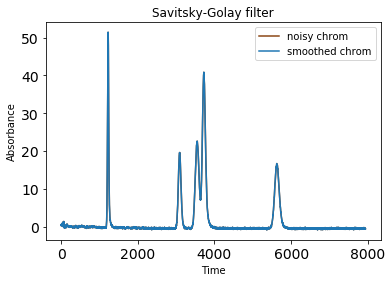

In [19]:
p = optimal_SG(c_noisy)

diff = len(c_noisy) - len(p)
plt.plot(c_noisy[int(diff/2):-int(diff/2)-1],color = "saddlebrown")
plt.ylabel("Absorbance")
plt.xlabel("Time")
plt.plot(p)
plt.legend(("noisy chrom","smoothed chrom"))
plt.title("Savitsky-Golay filter")
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()